In [3]:
pip install lxml[html_clean]

In [1]:
pip install transformers newspaper3k google-search-results

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 5.4 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13539 sha256=dc609cf51e0bfbd31b4771ace06c10ce30ce006def4b6aeada8307dd022de80a
  Stored in directory: /root/.cache/pip/wheels/c8/d6/6c/384f58df48c00b9a31d638005143b5b3ac62c3d25fb1447f23
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32009 sha256=cf6ba9a71f5f570330d4d210e94136d5db633ebe8a507986f72000fa88ff2322
  Stored in directory: /root/

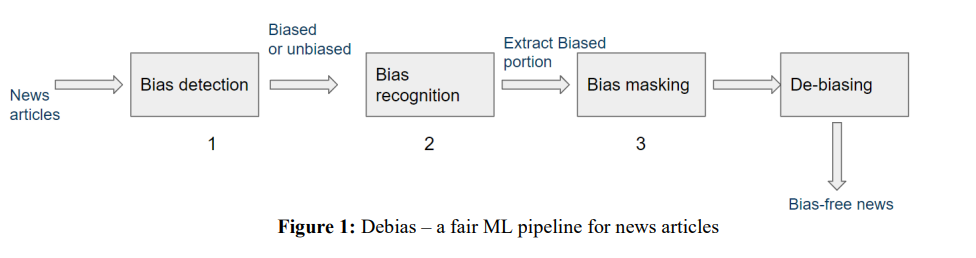

https://arxiv.org/pdf/2208.05777

In [13]:
import pandas as pd
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, pipeline
from newspaper import Article
from serpapi import GoogleSearch
from transformers import pipeline as text_generation_pipeline

# Load the bias detection model
tokenizer = AutoTokenizer.from_pretrained("d4data/bias-detection-model")
model = TFAutoModelForSequenceClassification.from_pretrained("d4data/bias-detection-model")
bias_classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

# Load sentiment analysis model
sentiment_model = pipeline("sentiment-analysis")

# Load summarization model
summarizer = pipeline("summarization")

# Load text generation model for de-biasing
debiasing_model = text_generation_pipeline("text2text-generation", model="t5-small")  # Example: T5 model

# Function to scrape article content
def scrape_article(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        return article.text
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

# Function to perform Google search and get news links
def google_news_search(query, num_results=5):
    api_key = "1be4a2bd9b3c979c700ea11f732fd7bc524160c605867cf5b92ddf443f2a0bfc"
    search = GoogleSearch({"q": query, "tbm": "nws", "api_key": api_key})
    results = search.get_dict()
    news_links = []

    for article in results.get("news_results", [])[:num_results]:
        news_links.append(article["link"])

    return news_links

# Bias Masking Function (Extracting biased part)
def extract_biased_part(text):
    biased_part = []
    # Tokenize text into sentences
    sentences = text.split(".")
    for sentence in sentences:
        bias_predictions = bias_classifier(sentence.strip())  # Classify each sentence
        label = bias_predictions[0]["label"]
        if label != "Neutral":
            biased_part.append(sentence.strip())
    return " ".join(biased_part)

# De-biasing function (Rewriting biased parts)
def debias_text(text):
    # Use a model to rephrase the biased text (example: using T5 or GPT models)
    debiased_text = debiasing_model(f"de-bias: {text}")  # Prompt for rephrasing biased text
    return debiased_text[0]['generated_text']

# Sentiment Analysis
def perform_sentiment_analysis(text):
    sentiment_result = sentiment_model(text)
    sentiment_label = sentiment_result[0]["label"]
    sentiment_score = sentiment_result[0]["score"]
    return sentiment_label, sentiment_score

# Summarization
def summarize_text(text):
    summary = summarizer(text, max_length=150, min_length=50, do_sample=False)
    return summary[0]['summary_text']

# Bias Interpretation
def interpret_bias(predictions):
    results = []
    for prediction in predictions:
        label = prediction["label"]
        score = prediction["score"]
        interpretation = ""
        if label == "Neutral":
            interpretation = "This article appears unbiased or balanced in its context."
        elif label == "Left-Leaning":
            interpretation = "The article may exhibit a bias toward left-leaning ideologies."
        elif label == "Right-Leaning":
            interpretation = "The article may exhibit a bias toward right-leaning ideologies."
        else:
            interpretation = f"The article may have a specific contextual bias: {label}."

        results.append({
            "Bias Label": label,
            "Bias Score": score,
            "Interpretation": interpretation
        })
    return results

# Main function to analyze bias, sentiment, and summarize articles
def analyze_and_process_articles(query, num_articles=5):
    print(f"Searching for news articles about: {query}")
    news_links = google_news_search(query, num_articles)

    if not news_links:
        print("No news links found.")
        return

    # Initialize a list to hold the data
    results_data = []

    for idx, link in enumerate(news_links, 1):
        print(f"\nArticle {idx}: {link}")
        article_text = scrape_article(link)

        if article_text:
            # Bias Analysis
            bias_predictions = bias_classifier(article_text[:512])  # Truncate to model's max input length
            bias_interpretation = interpret_bias(bias_predictions)

            # Sentiment Analysis
            sentiment_label, sentiment_score = perform_sentiment_analysis(article_text)

            # Summarization
            summary_text = summarize_text(article_text)

            # Bias Masking (Extracting biased parts)
            biased_part = extract_biased_part(article_text)

            # De-biasing (Rewriting biased parts)
            debiased_text = debias_text(biased_part) if biased_part else "No biased content found."

            # Append the results to the data list
            results_data.append({
                'Article URL': link,
                'Bias Result': bias_interpretation[0]["Bias Label"],
                'Bias Score': bias_interpretation[0]["Bias Score"],
                'Bias Interpretation': bias_interpretation[0]["Interpretation"],
                'Sentiment Label': sentiment_label,
                'Sentiment Score': sentiment_score,
                'Summary': summary_text,
                'Biased Part': biased_part,
                'Debiased Text': debiased_text
            })
        else:
            print("Could not analyze article.")

    # Convert the results into a DataFrame
    df_results = pd.DataFrame(results_data)
    return df_results

# Example usage
if __name__ == "__main__":
    query = "climate change"
    df = analyze_and_process_articles(query, num_articles=3)
    print("\nResults DataFrame:")
    print(df)


Some layers from the model checkpoint at d4data/bias-detection-model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at d4data/bias-detection-model and are newly initialized: ['dropout_199']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use 0
No model was supplied, defaulte

Searching for news articles about: climate change

Article 1: https://www.newscientist.com/article/2462510-climate-change-may-have-killed-ancient-hobbit-hominins/

Article 2: https://www.economist.com/leaders/2025/01/02/smarter-incentives-would-help-india-adapt-to-climate-change


Your max_length is set to 150, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)



Article 3: https://www.bloomberg.com/news/articles/2025-01-04/new-year-s-resolutions-for-2025-play-a-board-game-swap-out-meat


Your max_length is set to 150, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)



Results DataFrame:
                                         Article URL Bias Result  Bias Score  \
0  https://www.newscientist.com/article/2462510-c...      Biased    0.917527   
1  https://www.economist.com/leaders/2025/01/02/s...      Biased    0.863997   
2  https://www.bloomberg.com/news/articles/2025-0...     Neutral    0.754152   

  Sentiment Label  Sentiment Score  \
0        NEGATIVE         0.997890   
1        NEGATIVE         0.978706   
2        NEGATIVE         0.705599   

                                             Summary  \
0   Until about 50,000 years ago, Homo floresiens...   
1   Minimum temperatures last summer were the hig...   
2   Please make sure your browser supports JavaSc...   

                                         Biased Part  \
0  Homo floresiensis, a metre-tall ancient homini...   
1  F ew places illustrate the challenges of adapt...   
2  Why did this happen?\n\nPlease make sure your ...   

                                       Debiased Text  
0